<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/gpt_parallelized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# -Tidy code


## Hyperparameters

In [47]:
# hyperparameters
batch_size = 64 # num independent sequences processed in parallel 
block_size = 256 # maximum context length

max_iterations = 5001 # training iterations
eval_interval = 1000 # after how many iterations to print out loss & accuracy
eval_iterations = 50 # batches to average over during evaluation

train_split = 0.9

dropout = 0.2
# learning_rate = 3e-4

# model architecture
n_heads = 6
n_embedding = 384 # each head has dim 64 (=384/6)
n_layer = 3

## Imports 

In [48]:
try:
    import einops
except:
    print(f"einops not installed as required, installing...")
    !pip3 install einops
    import einops

from einops import rearrange, reduce, repeat

import torch
import torch.nn as nn
import time

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"on device: {device}")

on device: cuda


## Download and pre-process data

In [50]:
# Importing data
data_file_path = 'https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/foundation.txt'
import requests
r = requests.get(data_file_path)
text = r.text

# file = "foundation.txt"
# with open(file, 'r') as f:
#   text = f.read()

print(f"Length of foundation.txt: {len(text)} characters")
print(text[:250])

chars = sorted(list(set(text)))
n_chars = len(chars)
print(f"There are {n_chars} unique characters, namely: {''.join(chars)}")

ctoi = {ch:i for i, ch in enumerate(chars)} # characters to integers
itoc = {i:ch for i, ch in enumerate(chars)} # integers to character
encode = lambda s: [ctoi[ch] for ch in s]
decode = lambda l: ''.join([itoc[i] for i in l])
print(encode("Hello world!"))
print(decode(encode("Foo Bar!")))

encoded_text = encode(text)
print(len(encoded_text))

n = int(len(encoded_text) * 0.9)
data = torch.tensor(encoded_text, dtype=torch.long)
train_data = data[:n]
test_data = data[n:]
print(f"train data length {len(train_data)} | test data length {len(test_data)}")

Length of foundation.txt: 1240544 characters
FOUNDATION 
ISAAC ASIMOV 

PART I 

THE PSYCHOHISTORIANS 

i. 

HARI SELDON-... bom In the 1 1,988th year of the Galactic Era; died 12,069. The dates are 
more commonly given In terms of the current Foundational Era as - 79 to the year 1 F.E. Born 
t
There are 84 unique characters, namely: 
 !"#%'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ\abcdefghijklmnopqrstuvwxyz—‘’”
[34, 58, 65, 65, 68, 1, 76, 68, 71, 65, 57, 2]
Foo Bar!
1240544
train data length 1116489 | test data length 124055


In [51]:
def get_batches(split='train') -> tuple:
  data = train_data if split == 'train' else test_data
  idxs = torch.randint(len(data)-block_size, (batch_size, ))
  xb = torch.stack([data[i:i+block_size] for i in idxs])
  yb = torch.stack([data[i+1:i+block_size+1] for i in idxs])
  xb, yb = xb.to(device), yb.to(device)
  return xb, yb

xb, yb = get_batches()
print(xb.shape, yb.shape)

torch.Size([64, 256]) torch.Size([64, 256])


In [111]:
def evaluate_model(model, eval_iterations = eval_iterations, out_dict = False):
  t_eval = time.time()
  model.eval()
  with torch.inference_mode():
    splits = ['train', 'test']
    categories = ['loss', 'top1', 'top5']
    all = {s:{c: torch.zeros(eval_iterations) for c in categories} for s in splits}
    for split in splits:
      for i in range(eval_iterations):
        xb, yb = get_batches(split = split)
        logits, loss = model(xb, yb)
        all[split]['loss'][i] = loss.item()

        # top@1 accuracy
        top1_preds = torch.topk(logits, 1, dim = -1).indices.squeeze(dim=-1)
        all[split]['top1'][i] = 100*(torch.sum(top1_preds == yb) / torch.numel(yb)).item()

        # top@5 accuracy
        top5_preds = torch.topk(logits, 5, dim = -1).indices
        y_stretched = repeat(yb, 'B T -> B T K', K = 5)
        all[split]['top5'][i] = 100*(torch.sum(top5_preds == y_stretched) / torch.numel(yb)).item()
  model.train()

  output_dict = {split:list(map(lambda a: round(a.mean().item(), 4), all[split].values())) for split in splits}
  output_dict['eval_time'] = round(time.time()-t_eval, 2)
  if out_dict: return output_dict
  #Format output
  array = output_dict['train']+['|'] + output_dict['test'] + ['|'] + [output_dict['eval_time']]
  output_str = ""
  target_indexes = [0, 9, 18, 25, 27, 36, 45, 53, 54]
  for i in range(len(target_indexes)): output_str+=" "*(target_indexes[i]-len(output_str)) + f"{array[i]}"
  return output_str

evaluate_model(gpt_model, eval_iterations=5)


'1.3803   57.6306  87.0776| 1.4261   57.1204  86.2024 |0.83'

In [73]:
print(f"n_heads:{n_heads} | n_embedding: {n_embedding} | n_layer: {n_layer} num_params: {sum(p.numel() for p in gpt_model.parameters())/1e6:.4f} Million Parameters")
print("---------TRAIN----------|-----------TEST-----------|--TIMING----------")
print("loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time")
print(f" ### iter: {i} | loss: {loss.item():.4f} | train interval: {train_time:.2f} seconds")

n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters
---------TRAIN----------|-----------TEST-----------|--TIMING----------
loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
 ### iter: 1000 | loss: 1.4172 | train interval: 208.96 seconds


## GPT model

In [69]:
class MultiHeadAttention(nn.Module):
  # parallelized attention heads
  
  def __init__(self):
    super().__init__()
    head_size = n_embedding // n_heads
    self.head_size = head_size
    #generate q,k,v for all n_heads at once
    self.qkv_linear = nn.Linear(n_embedding, head_size*n_heads*3) 
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.linear = nn.Sequential(
        nn.Linear(head_size*n_heads, n_embedding),
        nn.Dropout(dropout))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    B,T,C = x.shape #[64, 256, 384])
    qkv = self.qkv_linear(x) # [64, 256, 1152]
    q, k, v =  rearrange(qkv, 'b t (qvk h c) -> qvk b h t c', qvk=3, h=n_heads) #torch.Size([3, 64, 6, 256, 64])

    mat_mul = q@rearrange(k, 'b h t c -> b h c t') * self.head_size**-0.5 # This scaling factor makes an INSANE difference
    mat_mul = mat_mul.masked_fill(self.tril[:T, :T]==0, float('-inf'))
    mat_mul = nn.functional.softmax(mat_mul, dim = -1)
    mat_mul = self.dropout(mat_mul)
    mat_mul = mat_mul@v
    flattened = rearrange(mat_mul, 'b h t c -> b t (h c)')
    linear = self.linear(flattened)
    return flattened

class FeedFoward(nn.Module):
  def __init__(self):
    super().__init__()
    self.feed_forward = nn.Sequential(
        nn.Linear(n_embedding, 4*n_embedding),
        nn.GELU(),
        nn.Linear(4*n_embedding, n_embedding),
        nn.Dropout(dropout))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.feed_forward(x)

class Transformer(nn.Module):

  def __init__(self):
    super().__init__()
    self.multi_attention = MultiHeadAttention() 
    self.feed_forward = FeedFoward()
    self.ln1 = nn.LayerNorm(n_embedding)
    self.ln2 = nn.LayerNorm(n_embedding)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x + self.multi_attention(self.ln1(x))
    x = x + self.feed_forward(self.ln2(x))
    return x

class GPT(nn.Module):
  def __init__(self):
      super().__init__()

      self.token_embedding = nn.Embedding(n_chars, n_embedding)
      self.positional_encoding = nn.Embedding(block_size, n_embedding)

      self.transformers = nn.Sequential(*[Transformer() for _ in range(n_layer)])

      self.final_ln = nn.LayerNorm(n_embedding)
      self.final_linear = nn.Linear(n_embedding, n_chars)

  def forward(self, x: torch.Tensor, targets = None) -> torch.Tensor:
    T = x.shape[-1]
    te = self.token_embedding(x) # [64, 256, 84]
    pe = self.positional_encoding(torch.arange(T, device = device))
    # print(f"te: {te.shape} | pe: {pe.shape}")
    x = te + pe # [64, 256, 128] (batch_size, T, n_embedding)
    x = self.transformers(x) # 

    x = self.final_ln(x)
    logits = self.final_linear(x)

    if targets == None:
      loss = None
    else:
      B, T, C = logits.shape
      logits_r = logits.view(B*T, C)
      targets_r = targets.view(B*T)
      loss = nn.functional.cross_entropy(logits_r, targets_r)
  
    return logits, loss

  @torch.no_grad()
  def generate(self, idxs, length_to_generate=500) -> torch.Tensor:
    self.eval()
    for _ in range(length_to_generate):
      input = idxs[:, -block_size:]
      logits, loss = self(input)
      logits = logits[:, -1, :] # (B, T)
      probs = nn.functional.softmax(logits, dim = -1)
      pred = torch.multinomial(probs, 1)
      idxs = torch.cat((idxs, pred), dim = -1) # (B, T+1)
    return idxs

gpt_model = GPT().to(device)
print(f'gpt model parameters are on device: {next(gpt_model.parameters()).device}')
xb, yb = get_batches()
logits, loss = gpt_model(xb, yb)
print(f"{logits.shape}, {loss.item():.4f}")
print(f"{sum(p.numel() for p in gpt_model.parameters())/1e6:.4f} Million Parameters")
print()
context = torch.zeros((1, 1), dtype = torch.long,  device = device)
print(decode(gpt_model.generate(context, length_to_generate=100)[0].tolist()))

gpt model parameters are on device: cuda:0
torch.Size([64, 256, 84]), 4.6227
5.4871 Million Parameters


..rt7fXOV!A?zFxLJPEoYl*A4m9\H‘ZmK0l0T0W-e;2 RPS
TC'-”,e:J8iZ?5-\47PfII;r’bA?rX6KbPgenGrgjgmDm‘(TwmJ,


## Training loop

In [70]:
### Training loop
learning_rate = 3e-4

optimizer = torch.optim.AdamW(params = gpt_model.parameters(), lr = learning_rate)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0, last_epoch=-1, verbose=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 200) # T_mult=2


In [71]:
losses = []
lrs = []

t_train = time.time()
t_train_full = time.time()
print(f"n_heads:{n_heads} | n_embedding: {n_embedding} | n_layer: {n_layer} num_params: {sum(p.numel() for p in gpt_model.parameters())/1e6:.4f} Million Parameters")
print("---------TRAIN----------|-----------TEST-----------|--TIMING----------")
print("loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time")
# for i in range(max_iterations):
for i in range(1001):
  xb, yb = get_batches()
  logits, loss = gpt_model(xb, yb)
  if i % eval_interval == 0:
    train_time = time.time()-t_train
    print(evaluate_model(gpt_model) + f" ### iter: {i} | loss: {loss.item():.4f} | train interval: {train_time:.2f} seconds")
    t_train = time.time()
  
  losses.append(loss.item())
  lrs.append(scheduler.get_last_lr())

  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
  scheduler.step()

print()
print(f"Time taken for {max_iterations} iterations: {time.time()-t_train_full:.2f} seconds")

n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters
---------TRAIN----------|-----------TEST-----------|--TIMING----------
loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
4.6203   1.0945   5.7430   4.6181   1.1322   5.8312   7.9947 ### iter: 0 | loss: 4.6246 | train interval: 0.01 seconds
1.3850   57.7322  86.8572  1.4196   57.1560  86.3207  7.8747 ### iter: 1000 | loss: 1.4172 | train interval: 208.96 seconds

Time taken for 5001 iterations: 224.97 seconds


In [ ]:
#Without lr scheduling:
# 1.6008   51.8492  83.8604  1.6299   51.4921  83.3701  29.4928 ### iter: 1000 | loss: 1.6817 | train interval: 40.49 seconds
# With: 
#  1.4235   56.5724  86.4524  1.4637   55.8688  85.8688  7.8572 ### iter: 1000 | loss: 1.5045 | train interval: 209.32 seconds
#  1.2842   60.4039  88.2113  1.3478   59.2382  87.2946  7.8786 ### iter: 1000 | loss: 1.3604 | train interval: 208.99 seconds
# With lr scheduling

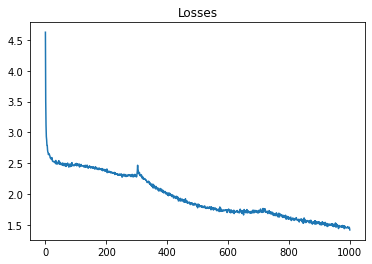

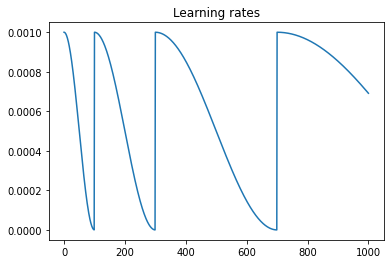

In [72]:
import matplotlib.pyplot as plt


plt.plot(losses)
plt.title("Losses")
plt.show()

plt.plot(lrs)
plt.title("Learning rates")
plt.show()

In [ ]:
# n_heads:6 | n_embedding: 384 | n_layer: 1 num_params: 1.9381 Million Parameters
# ---------TRAIN----------|-----------TEST-----------|--TIMING----------
# loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
# 4.6333   0.9825   5.1626   4.6361   0.9424   5.0534   10.8289### iter: 0 | loss: 4.6345 | train time interval: 0.01 seconds
# 2.5013   27.6460  66.2090  2.5089   27.8167  66.1908  10.9146### iter: 100 | loss: 2.5085 | train time interval: 7.76 seconds
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
# n_heads:6 | n_embedding: 384 | n_layer: 1 num_params: 1.9381 Million Parameters
# ---------TRAIN----------|-----------TEST-----------|--TIMING----------
# loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
# 4.6681   0.7924   4.6143   4.6686   0.7852   4.5937   10.1680### iter: 0 | loss: 4.6672 | train time interval: 0.01 seconds
# 2.5054   27.4399  65.9486  2.5082   27.7022  66.0398  10.2297### iter: 100 | loss: 2.5171 | train time interval: 6.53 seconds

# n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters
# ---------TRAIN----------|-----------TEST-----------|--TIMING----------
# loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
# 4.5404   1.0071   6.0883   4.5384   0.9906   6.0388   27.0759 ### iter: 0 | loss: 4.5422 | train interval: 0.01 seconds
# 1.6008   51.8492  83.8604  1.6299   51.4921  83.3701  29.4928 ### iter: 1000 | loss: 1.6817 | train interval: 40.49 seconds
# 1.3288   59.2941  87.6776  1.3815   58.2792  86.9174  29.4365 ### iter: 2000 | loss: 1.4048 | train interval: 40.43 seconds
# 1.2257   62.0692  88.9917  1.3111   60.4550  87.8633  29.5504 ### iter: 3000 | loss: 1.3113 | train interval: 40.44 seconds
# 1.1591   63.8813  89.7406  1.2798   61.5125  88.2186  29.9780 ### iter: 4000 | loss: 1.2632 | train interval: 40.42 seconds
# 1.1068   65.3377  90.3494  1.2654   62.0324  88.2828  29.5430 ### iter: 5000 | loss: 1.2179 | train interval: 40.44 seconds
# Time taken for 5001 iterations: 1770.78 seconds (would be 1000 seconds if I evaluated every 1000 iterations, not 200)
# Note: #16 mins of training time, and 12 mins of eval time. Should just check every 1000 iterations(accidentally set it to 200)

In [ ]:
context = torch.zeros((1, 1), dtype = torch.long,  device = device)
print(decode(gpt_model.generate(context, length_to_generate=200)[0].tolist()))

In [ ]:
for i in range(10):
  print("-"*100)
  sentence = "James Davey,"
  context= torch.tensor([encode(sentence)], dtype = torch.long, device = device)
  print(decode(gpt_model.generate(context, length_to_generate=200)[0].tolist()))